## Getting the data

Request all issues with personified token from github_apikey.key file. One can generate a token under https://github.com/settings/tokens

In [3]:
from github import Github
import pandas as pd

with open("github_apikey.key", 'r') as f:
    g = Github(f.read().replace("\n", ""))

repo = g.get_repo("networkx/networkx")
print(f"Connected to repo: {repo.name}")

issues = repo.get_issues(state='closed', sort='updated', direction='desc')


/tmp/ipykernel_6703/4156975577.py:5: DeprecationWarning: Argument login_or_token is deprecated, please use auth=github.Auth.Token(...) instead
  g = Github(f.read().replace("\n", ""))


Connected to repo: networkx


This next cell requests all the issues and puts them into combined data. **Warning:** The requesting takes over 1 hour

In [7]:
combined_data = {}

network_edges = []

raw_data = open("raw_data.txt", 'w')

for issue in issues:
    if not issue.user or not issue.title or not issue.body:
        continue

    issue_opener = issue.user.login
        
    issue_title = issue.title.replace("\n", " ").replace("\r", "")
    issue_body = issue.body.replace("\n", " ").replace("\r", "")

    combined_data.setdefault(issue_opener, []).append(("issue", issue_title + "#TITLE_END#" + issue_body))

    raw_data.write("issue:" + issue_opener + "\n" + issue_title + "\n" + issue_body + "\n")

    for comment in issue.get_comments():
        if not comment.user or not comment.body:
            continue
            
        commenter = comment.user.login

        if commenter == issue_opener:
            continue
        
        network_edges.append((commenter, issue_opener)) 
        
        comment_body = comment.body.replace("\n", " ").replace("\r", "")

        combined_data.setdefault(commenter, []).append(("comment", comment_body))

        raw_data.write("comment:" + commenter + "\n" + comment_body + "\n")
        
raw_data.close()


Request GET /repos/networkx/networkx/issues/2549/comments failed with 403: Forbidden
Setting next backoff to 501.166292s


In [8]:
all_comments = 0
all_issues = 0
for key, value in combined_data.items():
    issues_counter = 0
    comment_counter = 0
    for x in value:
        if x[0] == "issue":
            issues_counter += 1
        if x[0] == "comment":
            comment_counter += 1

    print(f"{key} issues:{issues_counter} comments:{comment_counter}")
    all_comments += comment_counter
    all_issues += issues_counter

print(f"all comments:{all_comments}, all issues:{all_issues}")


MridulS issues:222 comments:820
dschult issues:439 comments:4035
rossbar issues:541 comments:1116
bagrow issues:1 comments:0
williamjallen issues:2 comments:1
SultanOrazbayev issues:15 comments:15
jfinkels issues:167 comments:307
bjedwards issues:7 comments:52
tillahoffmann issues:4 comments:0
amcandio issues:27 comments:55
stairclimber issues:1 comments:0
Michael-E-Rose issues:31 comments:46
aphedges issues:1 comments:0
rudyarthur issues:3 comments:0
jarrodmillman issues:355 comments:410
stevenganz issues:3 comments:2
NeilGirdhar issues:17 comments:56
pep8speaks issues:0 comments:109
stefanv issues:12 comments:115
emmanuelle issues:0 comments:1
gjulianm issues:0 comments:2
fmagin issues:0 comments:17
memst issues:0 comments:2
songololo issues:1 comments:6
danieleades issues:15 comments:20
charmoniumQ issues:0 comments:5
tbrugere issues:0 comments:3
a-r-j issues:0 comments:3
petergtz issues:0 comments:1
olejorgenb issues:0 comments:1
psychedelicious issues:0 comments:1
flying-sheep iss

In [9]:
for x in network_edges:
    if x[0] == x[1]:
        print(x)
    

Save all data in files. Every user gets a file in the Data folder, where the name of the file is the username. Each file then contains first each issue of this user with one line "issue" and the next line the issue title and issue text, then all comments with first line "comment" and then the text of the comment.

In [12]:
for user, texts in combined_data.items():
    with open("Data/" + user + ".txt", "w") as f:
        # f.write(user + "\n")
        for type, text in texts:
            if type == "issue":
                f.write(type + "\n")
                f.write(text + "\n")
        for type, text in texts:
            if type == "comment":
                f.write(type + "\n")
                f.write(text + "\n")

In [11]:
edges_file = open("edges.txt", 'w')

for source, target in network_edges:
    edges_file.write(source + "," + target + "\n")

edges_file.close()

In [13]:
print(len(set(network_edges)))

4291


## Building the network

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
import os

edges_file = open("edges.txt", "r")

G = nx.DiGraph()

for line in edges_file:
    split_line = line.replace("\n",'').split(',')
    G.add_edge(split_line[0], split_line[1])

In [47]:
print(G)

DiGraph with 2165 nodes and 4291 edges


In [48]:
files = os.listdir("Data")

temp = []
for file in files:
    temp.append(file.replace(".txt", ''))

for node in G.nodes():
    if not node in temp:
        print(node)
        

In [49]:
largest = max(nx.weakly_connected_components(G), key=len)

G = G.subgraph(largest)

print("G is a " + str(G))

G is a DiGraph with 2155 nodes and 4286 edges


In [52]:
in_degree_sequence = sorted([d for d in G.in_degree()], key = (lambda x: x[1]), reverse=True)

out_degree_sequence = sorted([d for d in G.out_degree()], key = (lambda x: x[1]), reverse=True)

print(in_degree_sequence[0:10])
print(out_degree_sequence[0:10])

[('dschult', 75), ('rossbar', 61), ('MridulS', 60), ('jarrodmillman', 47), ('networkx-trac', 37), ('jfinkels', 35), ('NeilGirdhar', 33), ('hagberg', 24), ('ysitu', 23), ('chebee7i', 23)]
[('dschult', 1227), ('rossbar', 498), ('hagberg', 392), ('MridulS', 318), ('chebee7i', 140), ('jarrodmillman', 126), ('jfinkels', 118), ('pep8speaks', 70), ('ysitu', 61), ('jtorrents', 45)]


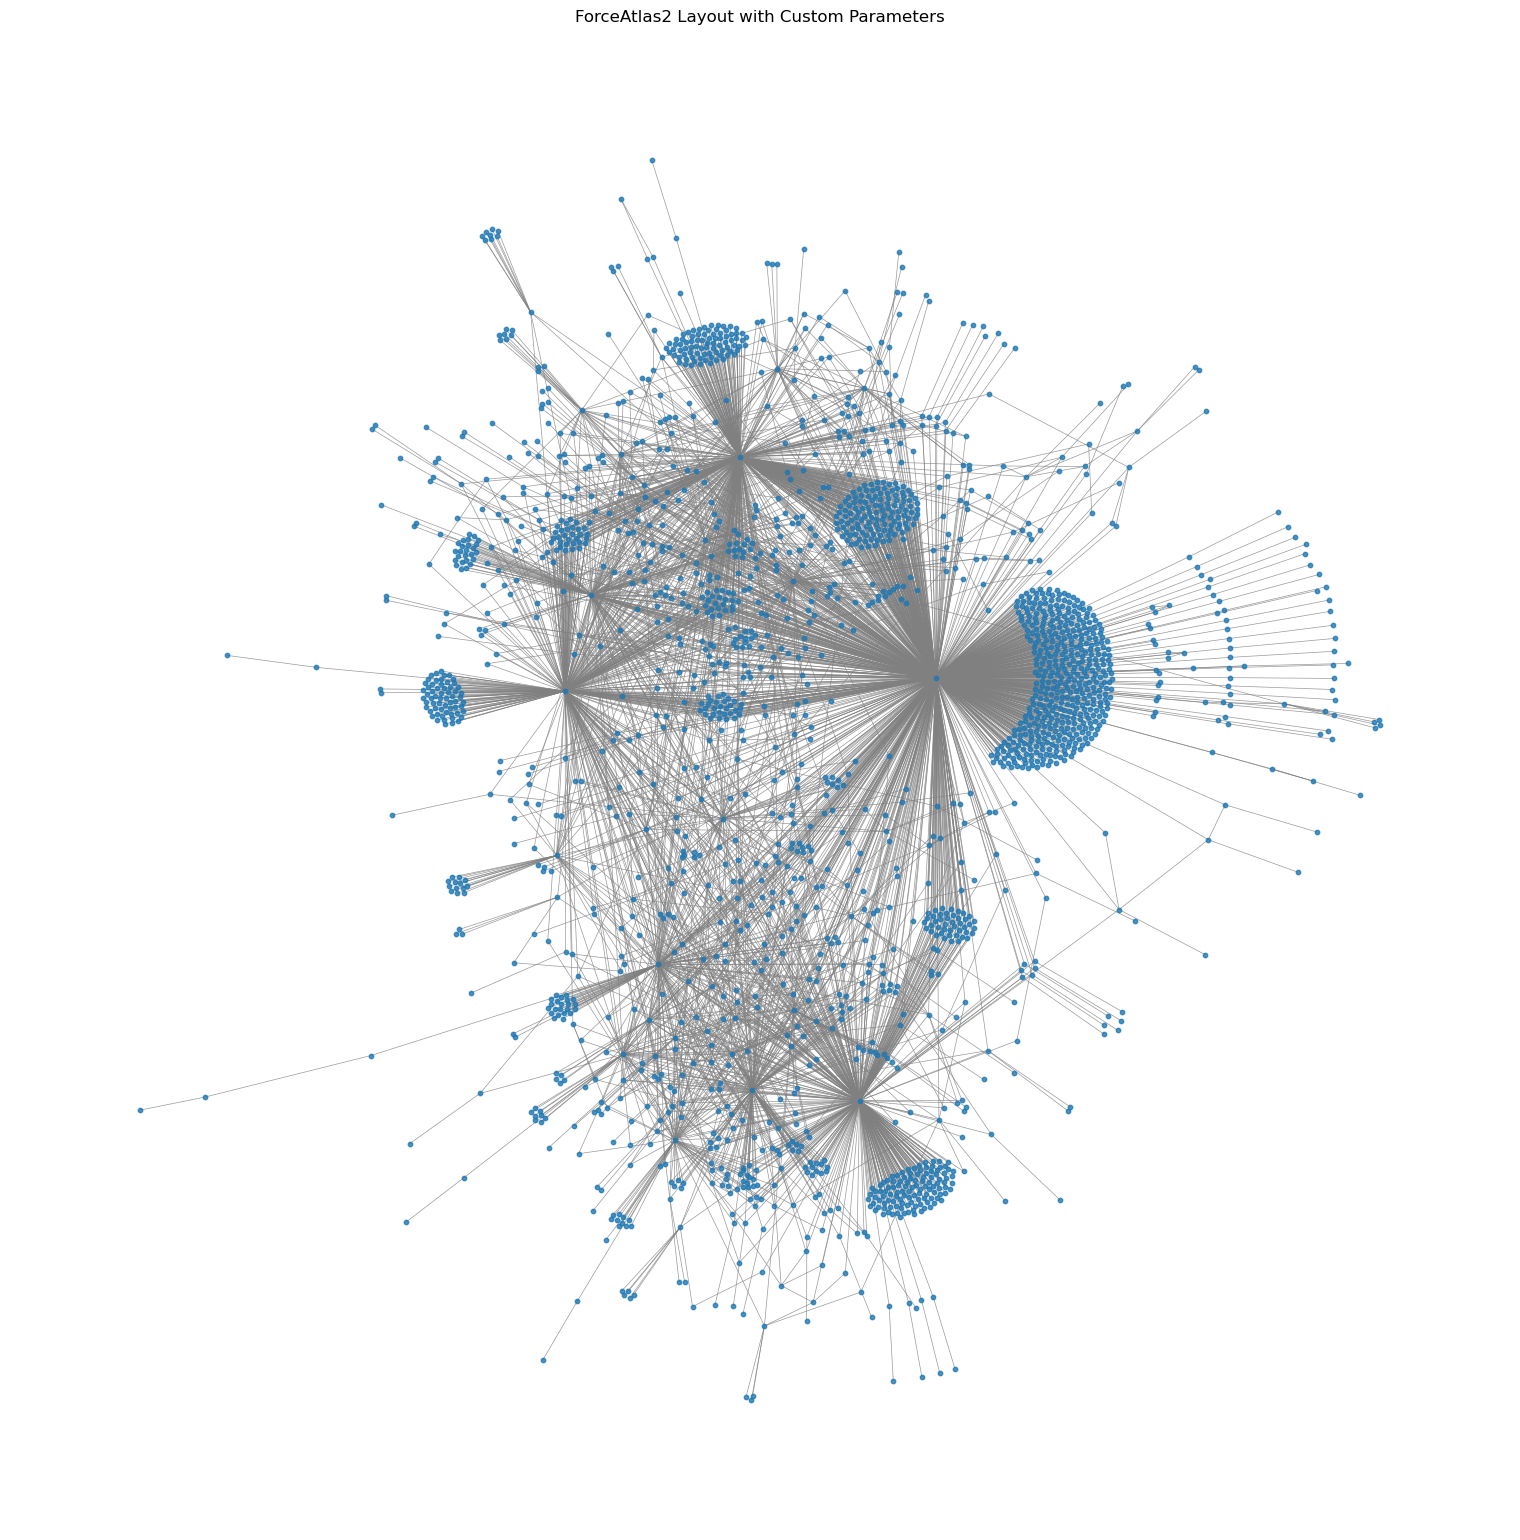

In [50]:
G_und = G.to_undirected()

pose = nx.forceatlas2_layout(G_und)

plt.figure(figsize=(15, 15))

nx.draw(
    G_und,
    pos=pose,
    node_size=10,
    alpha=0.8,
    edge_color='gray',
    width=0.5,
    with_labels=False
)

plt.title("ForceAtlas2 Layout with Custom Parameters")
plt.axis('off')
plt.show()